In [1]:
!pip install torch torchvision datasets matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [102]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from datasets import load_dataset


In [137]:
from torch.utils.data import ConcatDataset
dataset = load_dataset("cifar10")

def get_transform(augment=False):
    if augment:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.RandomRotation(2),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.4914, 0.4822, 0.4465),
                std=(0.2023, 0.1994, 0.2010)
            )
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=(0.4914, 0.4822, 0.4465),
                std=(0.2023, 0.1994, 0.2010)
            )
        ])




def transform_dataset(split, transform):
    images = [transform(img) for img in split['img']]
    labels = torch.tensor(split['label'])
    return list(zip(images, labels))

transform = get_transform(False)
augment_transform = get_transform(True)

full_train_dataset = transform_dataset(dataset['train'], transform)
augmented_train_dataset = transform_dataset(dataset['train'], augment_transform)
test_dataset = transform_dataset(dataset['test'], transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
augmented_train_dataset, _ = random_split(augmented_train_dataset, [train_size, val_size])
augmented_dataset = ConcatDataset([train_dataset, augmented_train_dataset])

In [138]:

def get_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
augmented_loader = DataLoader(augmented_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [139]:

class CIFAR10_CNN(nn.Module):
    def __init__(self, num_filters=32, num_layers=3):
        super().__init__()
        layers = []
        in_channels = 3
        for _ in range(num_layers):
            layers += [
                nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2)
            ]
            in_channels = num_filters
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_filters * (32 // (2 ** num_layers))**2, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [146]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.0005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        val_loss, correct, total = 0, 0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct / total)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies


def evaluate_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy


In [147]:
# Without Augmentation
model = CIFAR10_CNN()
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader)
evaluate_model(model, test_loader)

# With Augmentation
aug_model = CIFAR10_CNN()
aug_train_losses, aug_val_losses, aug_train_accuracies, aug_val_accuracies = train_model(aug_model, augmented_loader, val_loader)
evaluate_model(aug_model, test_loader)


Epoch 1/10 | Train Loss: 1.5058 | Val Loss: 1.2491 | Train Acc: 45.20% | Val Acc: 55.77%
Epoch 2/10 | Train Loss: 1.1563 | Val Loss: 1.0729 | Train Acc: 58.98% | Val Acc: 61.88%
Epoch 3/10 | Train Loss: 1.0050 | Val Loss: 1.0006 | Train Acc: 64.50% | Val Acc: 64.25%
Epoch 4/10 | Train Loss: 0.8967 | Val Loss: 0.9276 | Train Acc: 68.60% | Val Acc: 67.45%
Epoch 5/10 | Train Loss: 0.8203 | Val Loss: 0.8882 | Train Acc: 70.97% | Val Acc: 69.09%
Epoch 6/10 | Train Loss: 0.7499 | Val Loss: 0.8349 | Train Acc: 73.53% | Val Acc: 70.44%
Epoch 7/10 | Train Loss: 0.7013 | Val Loss: 0.8269 | Train Acc: 75.20% | Val Acc: 71.36%
Epoch 8/10 | Train Loss: 0.6515 | Val Loss: 0.8331 | Train Acc: 77.01% | Val Acc: 71.27%
Epoch 9/10 | Train Loss: 0.6082 | Val Loss: 0.7868 | Train Acc: 78.44% | Val Acc: 72.51%
Epoch 10/10 | Train Loss: 0.5710 | Val Loss: 0.7762 | Train Acc: 79.85% | Val Acc: 72.84%
Accuracy: 72.53%
Epoch 1/10 | Train Loss: 1.3474 | Val Loss: 1.0601 | Train Acc: 51.28% | Val Acc: 62.24%
Epo

74.66

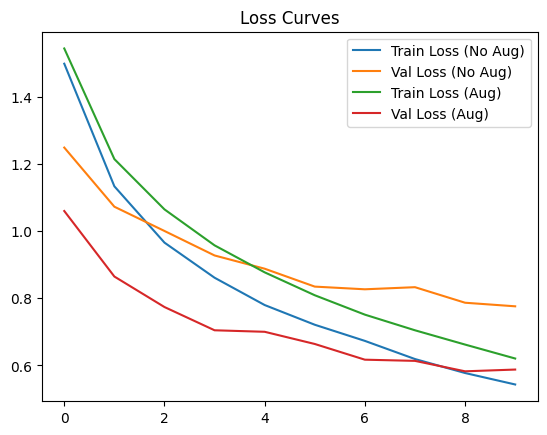

In [148]:

plt.plot(losses, label='Train Loss (No Aug)')
plt.plot(val_losses, label='Val Loss (No Aug)')
plt.plot(aug_losses, label='Train Loss (Aug)')
plt.plot(aug_val_losses, label='Val Loss (Aug)')
plt.legend()
plt.title('Loss Curves')
plt.show()


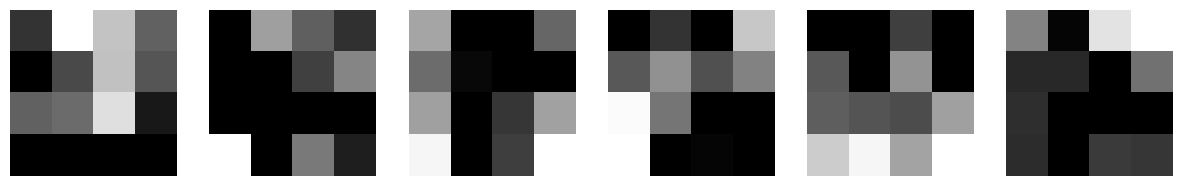

In [149]:
def visualize_feature_maps(model, image):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        features = model.features(image.unsqueeze(0).to(device)).cpu()

    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    for i in range(6):
        axes[i].imshow(features[0][i], cmap='gray')
        axes[i].axis('off')
    plt.show()

sample_img, _ = test_dataset[0]
visualize_feature_maps(model, sample_img)


In [150]:
learning_rates = [0.001, 0.01, 0.1]
learning_rate_results = {}

for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    model = CIFAR10_CNN()
    train_model(model, train_loader, val_loader, epochs=5, lr=lr)
    acc = evaluate_model(model, test_loader)
    learning_rate_results[lr] = acc

print("\nLearning Rate Results:", learning_rate_results)



Learning Rate: 0.001
Epoch 1/5 | Train Loss: 1.4373 | Val Loss: 1.2193 | Train Acc: 47.84% | Val Acc: 56.67%
Epoch 2/5 | Train Loss: 1.0635 | Val Loss: 0.9689 | Train Acc: 62.20% | Val Acc: 65.99%
Epoch 3/5 | Train Loss: 0.9011 | Val Loss: 0.8792 | Train Acc: 68.16% | Val Acc: 68.94%
Epoch 4/5 | Train Loss: 0.7959 | Val Loss: 0.8955 | Train Acc: 72.06% | Val Acc: 68.71%
Epoch 5/5 | Train Loss: 0.7229 | Val Loss: 0.8437 | Train Acc: 74.61% | Val Acc: 70.54%
Accuracy: 69.69%

Learning Rate: 0.01
Epoch 1/5 | Train Loss: 1.9268 | Val Loss: 1.7903 | Train Acc: 29.05% | Val Acc: 35.30%
Epoch 2/5 | Train Loss: 1.7743 | Val Loss: 1.7642 | Train Acc: 35.75% | Val Acc: 34.72%
Epoch 3/5 | Train Loss: 1.7297 | Val Loss: 1.7245 | Train Acc: 36.74% | Val Acc: 36.75%
Epoch 4/5 | Train Loss: 1.6992 | Val Loss: 1.6795 | Train Acc: 37.96% | Val Acc: 39.15%
Epoch 5/5 | Train Loss: 1.6722 | Val Loss: 1.6624 | Train Acc: 38.72% | Val Acc: 39.73%
Accuracy: 39.82%

Learning Rate: 0.1
Epoch 1/5 | Train Loss:

In [151]:
batch_sizes = [16, 32, 64]
batch_size_results = {}

for bs in batch_sizes:
    print(f"\nBatch Size: {bs}")
    train_loader = get_dataloader(train_dataset, bs)
    val_loader = DataLoader(val_dataset, batch_size=bs)
    test_loader = DataLoader(test_dataset, batch_size=bs)

    model = CIFAR10_CNN()
    train_model(model, train_loader, val_loader, epochs=5)
    acc = evaluate_model(model, test_loader)
    batch_size_results[bs] = acc

print("\nBatch Size Results:", batch_size_results)



Batch Size: 16
Epoch 1/5 | Train Loss: 1.4580 | Val Loss: 1.2097 | Train Acc: 47.15% | Val Acc: 56.55%
Epoch 2/5 | Train Loss: 1.0774 | Val Loss: 1.0133 | Train Acc: 61.80% | Val Acc: 64.03%
Epoch 3/5 | Train Loss: 0.9235 | Val Loss: 0.9076 | Train Acc: 67.50% | Val Acc: 67.51%
Epoch 4/5 | Train Loss: 0.8219 | Val Loss: 0.9294 | Train Acc: 71.21% | Val Acc: 67.99%
Epoch 5/5 | Train Loss: 0.7468 | Val Loss: 0.8456 | Train Acc: 73.75% | Val Acc: 70.63%
Accuracy: 70.52%

Batch Size: 32
Epoch 1/5 | Train Loss: 1.5139 | Val Loss: 1.2379 | Train Acc: 45.31% | Val Acc: 55.73%
Epoch 2/5 | Train Loss: 1.1438 | Val Loss: 1.0504 | Train Acc: 59.45% | Val Acc: 62.63%
Epoch 3/5 | Train Loss: 0.9884 | Val Loss: 0.9438 | Train Acc: 65.31% | Val Acc: 66.45%
Epoch 4/5 | Train Loss: 0.8812 | Val Loss: 0.9814 | Train Acc: 69.04% | Val Acc: 65.88%
Epoch 5/5 | Train Loss: 0.8051 | Val Loss: 0.8653 | Train Acc: 71.79% | Val Acc: 69.33%
Accuracy: 69.56%

Batch Size: 64
Epoch 1/5 | Train Loss: 1.6261 | Val L

In [12]:
filter_sizes = [16, 32, 64]
filter_results = {}

for filters in filter_sizes:
    print(f"\nNumber of Filters: {filters}")
    model = CIFAR10_CNN(num_filters=filters)
    train_model(model, train_loader, val_loader, epochs=5)
    acc = evaluate_model(model, test_loader)
    filter_results[filters] = acc

print("\nFilter Size Results:", filter_results)



Number of Filters: 16
Epoch 1/5 | Train Loss: 1.7031 | Val Loss: 1.4281
Epoch 2/5 | Train Loss: 1.3686 | Val Loss: 1.2749
Epoch 3/5 | Train Loss: 1.2325 | Val Loss: 1.1678
Epoch 4/5 | Train Loss: 1.1422 | Val Loss: 1.0985
Epoch 5/5 | Train Loss: 1.0632 | Val Loss: 1.0475
Accuracy: 61.93%

Number of Filters: 32
Epoch 1/5 | Train Loss: 1.5664 | Val Loss: 1.2751
Epoch 2/5 | Train Loss: 1.2098 | Val Loss: 1.1023
Epoch 3/5 | Train Loss: 1.0481 | Val Loss: 0.9869
Epoch 4/5 | Train Loss: 0.9313 | Val Loss: 0.9568
Epoch 5/5 | Train Loss: 0.8528 | Val Loss: 0.9352
Accuracy: 66.65%

Number of Filters: 64
Epoch 1/5 | Train Loss: 1.4635 | Val Loss: 1.2257
Epoch 2/5 | Train Loss: 1.0625 | Val Loss: 0.9636
Epoch 3/5 | Train Loss: 0.8875 | Val Loss: 0.8965
Epoch 4/5 | Train Loss: 0.7601 | Val Loss: 0.8247
Epoch 5/5 | Train Loss: 0.6703 | Val Loss: 0.8061
Accuracy: 71.87%

Filter Size Results: {16: 61.93, 32: 66.65, 64: 71.87}


In [20]:
layer_counts = [3, 5, 7]
layer_results = {}

for layers in layer_counts:
    try:
        print(f"\nNumber of Layers: {layers}")
        model = CIFAR10_CNN(num_layers=layers)
        train_model(model, train_loader, val_loader, epochs=5)
        acc = evaluate_model(model, test_loader)
        layer_results[layers] = acc
    except RuntimeError as e:
        print(f"❌ Skipping {layers} layers due to error: {e}")



Number of Layers: 3
Epoch 1/5 | Train Loss: 1.5790 | Val Loss: 1.2887
Epoch 2/5 | Train Loss: 1.2058 | Val Loss: 1.0895
Epoch 3/5 | Train Loss: 1.0370 | Val Loss: 1.0235
Epoch 4/5 | Train Loss: 0.9268 | Val Loss: 0.9329
Epoch 5/5 | Train Loss: 0.8499 | Val Loss: 0.8637
Accuracy: 69.29%

Number of Layers: 5
Epoch 1/5 | Train Loss: 1.7376 | Val Loss: 1.4559
Epoch 2/5 | Train Loss: 1.3788 | Val Loss: 1.2511
Epoch 3/5 | Train Loss: 1.2190 | Val Loss: 1.1373
Epoch 4/5 | Train Loss: 1.0945 | Val Loss: 1.0927
Epoch 5/5 | Train Loss: 1.0000 | Val Loss: 0.9609
Accuracy: 64.58%

Number of Layers: 7
❌ Skipping 7 layers due to error: Given input size: (32x1x1). Calculated output size: (32x0x0). Output size is too small


In [154]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to compute metrics
def compute_metrics(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    return acc, precision, recall, f1, cm

# ---------- Train and evaluate without augmentation ----------
# Loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model without augmentation
model_without_aug = CIFAR10_CNN()
train_model(model_without_aug, train_loader, val_loader, epochs=10)
acc1, precision1, recall1, f1_1, cm1 = compute_metrics(model_without_aug, test_loader)

# ---------- Train and evaluate with augmentation ----------
# Loaders with augmented data
from torch.utils.data import ConcatDataset
aug_train_dataset = ConcatDataset([train_dataset, augmented_train_dataset])
augmented_train_loader = DataLoader(aug_train_dataset, batch_size=batch_size, shuffle=True)

# Model with augmentation
model_with_aug = CIFAR10_CNN()
train_model(model_with_aug, augmented_train_loader, val_loader, epochs=10)
acc2, precision2, recall2, f1_2, cm2 = compute_metrics(model_with_aug, test_loader)

# ---------- Create comparison table ----------
metrics_table = pd.DataFrame({
    "Model": ["Without Augmentation", "With Augmentation"],
    "Accuracy": [acc1 * 100, acc2 * 100],
    "Precision": [precision1 * 100, precision2 * 100],
    "Recall": [recall1 * 100, recall2 * 100],
    "F1-Score": [f1_1 * 100, f1_2 * 100]
})

print("\n📊 Performance Metrics Comparison of CNN Models:\n")
print(metrics_table.to_string(index=False))




Epoch 1/10 | Train Loss: 1.5877 | Val Loss: 1.3594 | Train Acc: 42.27% | Val Acc: 51.24%
Epoch 2/10 | Train Loss: 1.2530 | Val Loss: 1.1734 | Train Acc: 55.24% | Val Acc: 58.63%
Epoch 3/10 | Train Loss: 1.0987 | Val Loss: 1.0552 | Train Acc: 61.26% | Val Acc: 62.96%
Epoch 4/10 | Train Loss: 0.9944 | Val Loss: 0.9814 | Train Acc: 65.05% | Val Acc: 65.24%
Epoch 5/10 | Train Loss: 0.9162 | Val Loss: 0.9638 | Train Acc: 67.79% | Val Acc: 66.35%
Epoch 6/10 | Train Loss: 0.8515 | Val Loss: 0.9162 | Train Acc: 70.39% | Val Acc: 68.08%
Epoch 7/10 | Train Loss: 0.8012 | Val Loss: 0.8889 | Train Acc: 72.10% | Val Acc: 68.88%
Epoch 8/10 | Train Loss: 0.7560 | Val Loss: 0.8816 | Train Acc: 73.64% | Val Acc: 69.69%
Epoch 9/10 | Train Loss: 0.7103 | Val Loss: 0.8833 | Train Acc: 75.21% | Val Acc: 69.29%
Epoch 10/10 | Train Loss: 0.6772 | Val Loss: 0.8373 | Train Acc: 76.20% | Val Acc: 71.07%
Epoch 1/10 | Train Loss: 1.4283 | Val Loss: 1.1693 | Train Acc: 48.76% | Val Acc: 58.80%
Epoch 2/10 | Train L

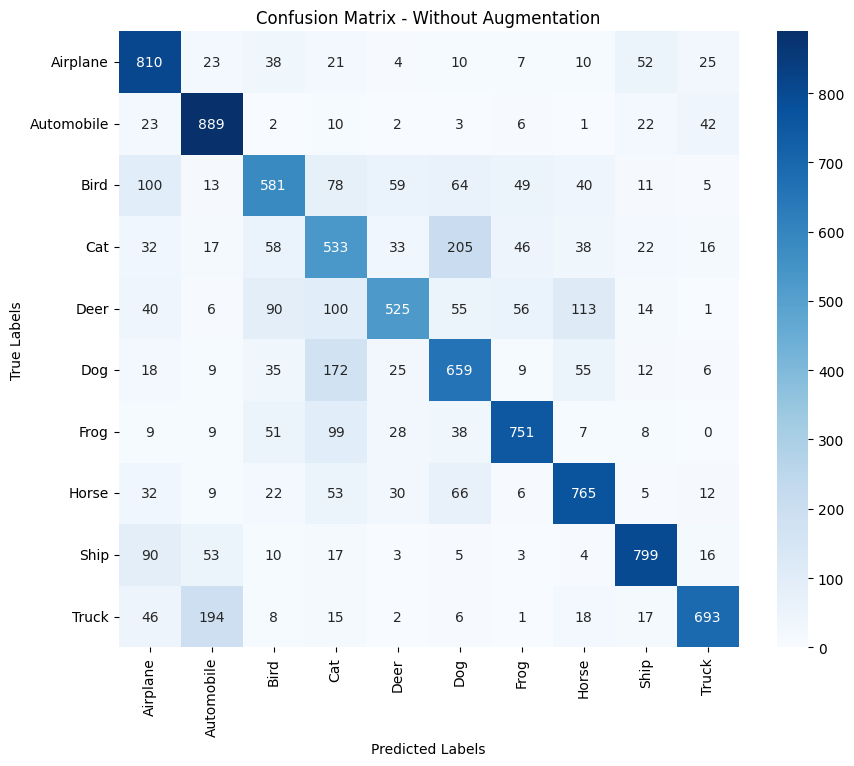

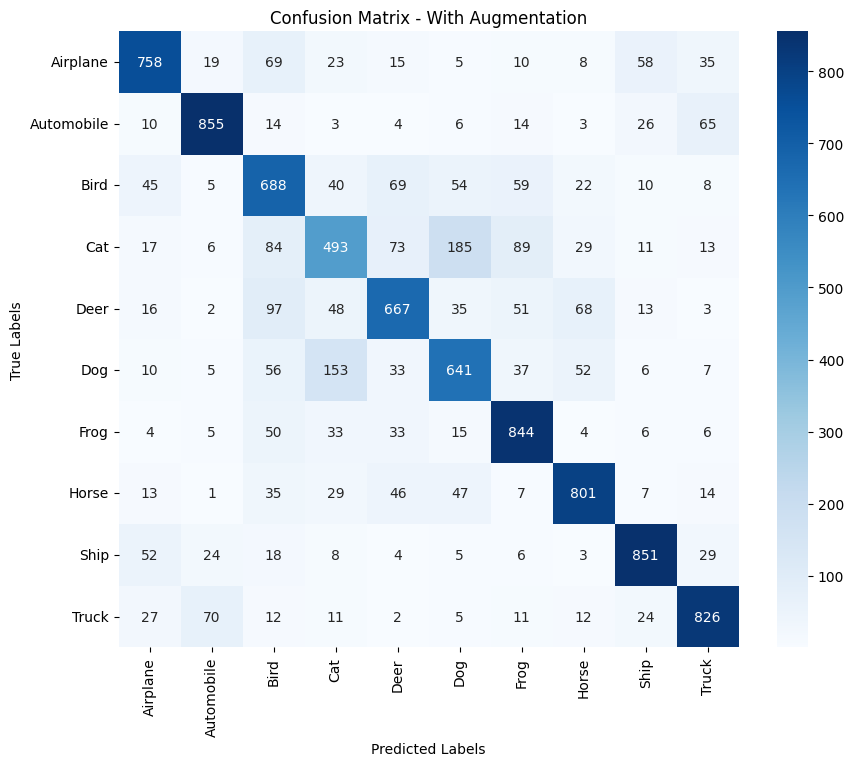

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# CIFAR-10 class names
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
           'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()

# Plot confusion matrix for model without augmentation
plot_confusion_matrix(cm1, "Confusion Matrix - Without Augmentation")

# Plot confusion matrix for model with augmentation
plot_confusion_matrix(cm2, "Confusion Matrix - With Augmentation")


In [156]:
# Analyze misclassified categories
def analyze_misclassifications(cm):
    np.fill_diagonal(cm, 0)  # Ignore correct classifications
    max_value = np.max(cm)
    indices = np.unravel_index(np.argmax(cm), cm.shape)
    true_class = classes[indices[0]]
    predicted_class = classes[indices[1]]
    print(f"Most misclassified: '{true_class}' as '{predicted_class}' ({max_value} times)")

print("\nWithout Augmentation Misclassifications:")
analyze_misclassifications(cm1)

print("\nWith Augmentation Misclassifications:")
analyze_misclassifications(cm2)



Without Augmentation Misclassifications:
Most misclassified: 'Cat' as 'Dog' (205 times)

With Augmentation Misclassifications:
Most misclassified: 'Cat' as 'Dog' (185 times)


In [157]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title(f'{title} - Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.show()


Epoch 1/10 | Train Loss: 1.5901 | Val Loss: 1.3330 | Train Acc: 42.31% | Val Acc: 52.31%
Epoch 2/10 | Train Loss: 1.2518 | Val Loss: 1.1670 | Train Acc: 54.94% | Val Acc: 58.74%
Epoch 3/10 | Train Loss: 1.1000 | Val Loss: 1.0768 | Train Acc: 60.99% | Val Acc: 62.26%
Epoch 4/10 | Train Loss: 1.0008 | Val Loss: 1.0121 | Train Acc: 64.90% | Val Acc: 64.45%
Epoch 5/10 | Train Loss: 0.9262 | Val Loss: 0.9420 | Train Acc: 67.52% | Val Acc: 66.96%
Epoch 6/10 | Train Loss: 0.8665 | Val Loss: 0.9326 | Train Acc: 69.58% | Val Acc: 67.30%
Epoch 7/10 | Train Loss: 0.8058 | Val Loss: 0.8948 | Train Acc: 71.91% | Val Acc: 68.62%
Epoch 8/10 | Train Loss: 0.7644 | Val Loss: 0.9050 | Train Acc: 73.27% | Val Acc: 68.10%
Epoch 9/10 | Train Loss: 0.7203 | Val Loss: 0.8552 | Train Acc: 75.10% | Val Acc: 69.21%
Epoch 10/10 | Train Loss: 0.6825 | Val Loss: 0.8635 | Train Acc: 76.18% | Val Acc: 70.21%


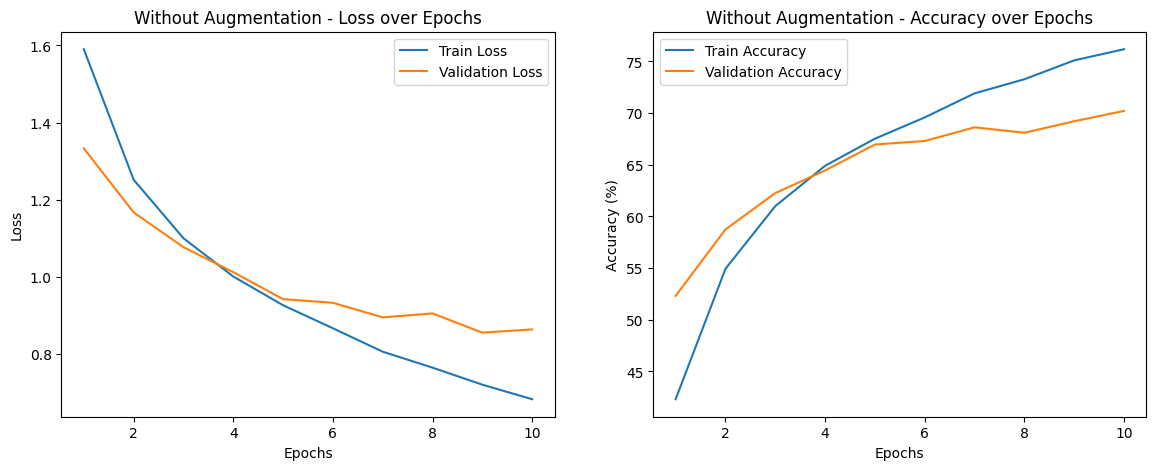

Epoch 1/10 | Train Loss: 1.4213 | Val Loss: 1.1572 | Train Acc: 48.63% | Val Acc: 58.73%
Epoch 2/10 | Train Loss: 1.0340 | Val Loss: 0.9305 | Train Acc: 63.74% | Val Acc: 67.48%
Epoch 3/10 | Train Loss: 0.8850 | Val Loss: 0.8505 | Train Acc: 69.14% | Val Acc: 70.54%
Epoch 4/10 | Train Loss: 0.7875 | Val Loss: 0.7705 | Train Acc: 72.63% | Val Acc: 72.90%
Epoch 5/10 | Train Loss: 0.7131 | Val Loss: 0.7236 | Train Acc: 75.11% | Val Acc: 74.61%
Epoch 6/10 | Train Loss: 0.6503 | Val Loss: 0.6874 | Train Acc: 77.40% | Val Acc: 76.02%
Epoch 7/10 | Train Loss: 0.5995 | Val Loss: 0.6931 | Train Acc: 79.10% | Val Acc: 76.16%
Epoch 8/10 | Train Loss: 0.5520 | Val Loss: 0.6487 | Train Acc: 80.85% | Val Acc: 77.61%
Epoch 9/10 | Train Loss: 0.5091 | Val Loss: 0.6533 | Train Acc: 82.27% | Val Acc: 77.52%
Epoch 10/10 | Train Loss: 0.4727 | Val Loss: 0.6181 | Train Acc: 83.65% | Val Acc: 79.01%


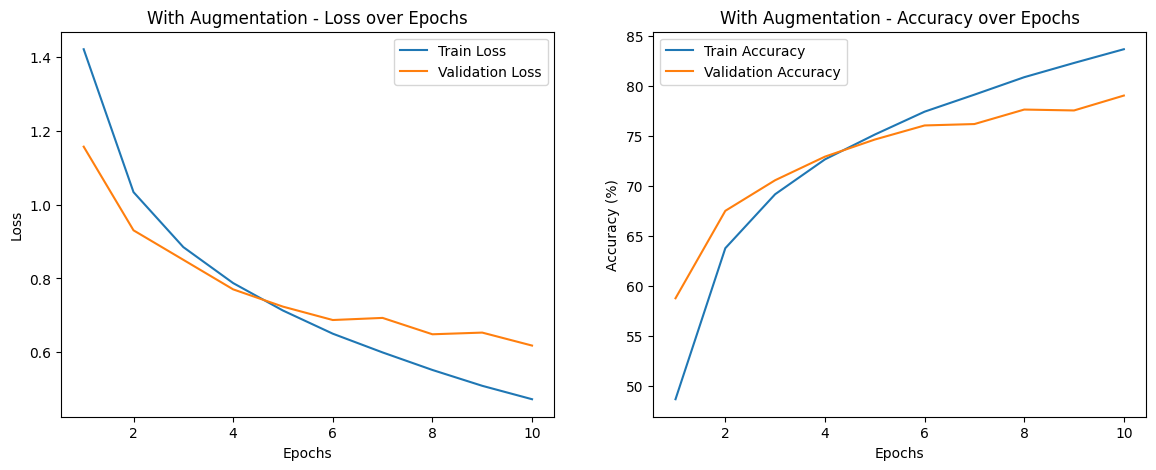

In [160]:
# Without Augmentation
model_no_aug = CIFAR10_CNN()
train_losses_no_aug, val_losses_no_aug, train_acc_no_aug, val_acc_no_aug = train_model(
    model_no_aug, train_loader, val_loader, epochs=10
)
plot_loss_accuracy(train_losses_no_aug, val_losses_no_aug, train_acc_no_aug, val_acc_no_aug, 'Without Augmentation')

# With Augmentation
model_aug = CIFAR10_CNN()
train_losses_aug, val_losses_aug, train_acc_aug, val_acc_aug = train_model(
    model_aug, augmented_train_loader, val_loader, epochs=10
)
plot_loss_accuracy(train_losses_aug, val_losses_aug, train_acc_aug, val_acc_aug, 'With Augmentation')
